**Library Import**

In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers,models,optimizers

2024-05-04 17:17:30.226664: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 17:17:30.226822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 17:17:30.392933: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print(f"Tensorflow version -- {tf.version.VERSION}")

Tensorflow version -- 2.15.0


**Data Loading**

In [3]:
train_df = pd.read_csv('../input/bigmartsalesdata/train.csv')
test_df = pd.read_csv('../input/bigmartsalesdata/test.csv')


In [4]:
train_df.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


**Dataset Exploration**

In [5]:
train_df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


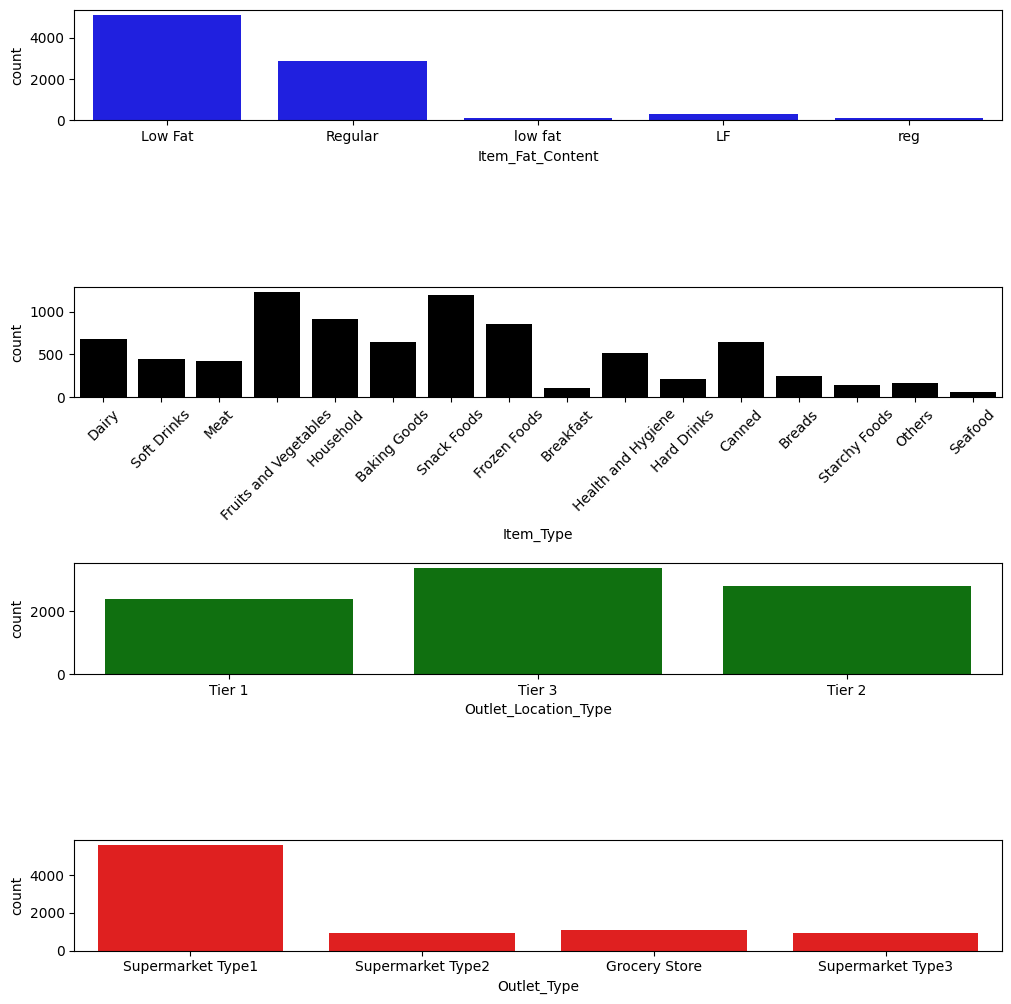

In [7]:
# Creating Graph for categorical data type
fig,ax = plt.subplots(4,1, figsize=(10,10))
fig.tight_layout()
plt.subplots_adjust(hspace=1.5)
sns.countplot(data = train_df,x = 'Item_Fat_Content',color='b',ax=ax[0]);
sns.countplot(data = train_df,x = 'Item_Type',color='k',ax=ax[1]);
ax[1].tick_params(axis='x', rotation=45)
sns.countplot(data = train_df,x = 'Outlet_Location_Type',color='g',ax=ax[2]);
sns.countplot(data = train_df,x = 'Outlet_Type',color='r',ax=ax[3]);

**Data Wrangling**

In [8]:
# Checking Null Values
train_df.isnull().sum().sort_values(ascending=False)

Outlet_Size                  2410
Item_Weight                  1463
Item_Identifier                 0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [9]:
# Substituting NaN values for Item Weight
train_df[['Item_Weight']] = train_df[['Item_Weight']].fillna(value=train_df['Item_Weight'].mean())
# Substituting 0 values for Item Weight
train_df['Item_Visibility']=train_df['Item_Visibility'].mask(train_df['Item_Visibility']==0).fillna(train_df['Item_Visibility'].mean())

In [10]:
# Imputing the values for Outlet_Size
#Determing the mode for each
outlet_size_mode = train_df.Outlet_Size.groupby(train_df['Outlet_Type']).apply(lambda g: g.mode()).reset_index()[['Outlet_Type', 'Outlet_Size']]
print('Mode for each Outlet_Type:')
print(outlet_size_mode)

# Creating Dictionary Outlet_Type:Outlet_Size
outlet_size_mode_dict = outlet_size_mode.set_index('Outlet_Type')['Outlet_Size'].to_dict()

#Get a boolean variable specifying missing  Outlet_Size values
miss_bool = train_df['Outlet_Size'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
train_df.loc[miss_bool,'Outlet_Size'] = train_df.loc[miss_bool,'Outlet_Type'].apply(lambda x: outlet_size_mode_dict[x])

Mode for each Outlet_Type:
         Outlet_Type Outlet_Size
0      Grocery Store       Small
1  Supermarket Type1       Small
2  Supermarket Type2      Medium
3  Supermarket Type3      Medium


In [11]:
# Checking Null Values
train_df.isnull().sum().sort_values(ascending=False)

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [12]:
# Modifying Item_Fat_Content Column values
train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print(train_df['Item_Fat_Content'].value_counts())

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64


In [13]:
# Creating new column to replace Item_Type
#Get the first two characters of ID:
train_df['Item_Type_Combined'] = train_df['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
train_df['Item_Type_Combined'] = train_df['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
print(train_df['Item_Type_Combined'].value_counts())

Item_Type_Combined
Food              6125
Non-Consumable    1599
Drinks             799
Name: count, dtype: int64


In [14]:
#Mark non-consumables as separate category in low_fat:
train_df.loc[train_df['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
train_df['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat       3918
Regular       3006
Non-Edible    1599
Name: count, dtype: int64

In [15]:
#Years:
train_df['Outlet_Years'] = 2013 - train_df['Outlet_Establishment_Year']
print(train_df['Outlet_Years'].describe())

count    8523.000000
mean       15.168133
std         8.371760
min         4.000000
25%         9.000000
50%        14.000000
75%        26.000000
max        28.000000
Name: Outlet_Years, dtype: float64


In [16]:
# Dropping Columns - Outlet_Size,Item_Identifier,Outlet_Identifier
train_df = train_df.drop(['Item_Type','Outlet_Establishment_Year'],axis=1)

In [33]:
train_df.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Type_Combined,Outlet_Years
0,FDA15,9.30,Low Fat,0.016047,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,Food,14
1,DRC01,5.92,Regular,0.019278,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,Drinks,4
2,FDN15,17.50,Low Fat,0.016760,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,Food,14
3,FDX07,19.20,Regular,0.066132,182.0950,OUT010,Small,Tier 3,Grocery Store,732.3800,Food,15
4,NCD19,8.93,Non-Edible,0.066132,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052,Non-Consumable,26


**Data Preparation**

In [17]:
#Label Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#New variable for outlet
train_df['Outlet'] = le.fit_transform(train_df['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    train_df[i] = le.fit_transform(train_df[i])

In [18]:
train_df.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Type_Combined,Outlet_Years,Outlet
0,FDA15,9.30,0,0.016047,249.8092,OUT049,1,0,1,3735.1380,1,14,9
1,DRC01,5.92,2,0.019278,48.2692,OUT018,1,2,2,443.4228,0,4,3
2,FDN15,17.50,0,0.016760,141.6180,OUT049,1,0,1,2097.2700,1,14,9
3,FDX07,19.20,2,0.066132,182.0950,OUT010,2,2,0,732.3800,1,15,0
4,NCD19,8.93,1,0.066132,53.8614,OUT013,0,2,1,994.7052,2,26,1


In [19]:
#One Hot Coding:
train_df = pd.get_dummies(train_df, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined','Outlet'])

In [20]:
train_df.dtypes

Item_Identifier            object
Item_Weight               float64
Item_Visibility           float64
Item_MRP                  float64
Outlet_Identifier          object
Item_Outlet_Sales         float64
Outlet_Years                int64
Item_Fat_Content_0           bool
Item_Fat_Content_1           bool
Item_Fat_Content_2           bool
Outlet_Location_Type_0       bool
Outlet_Location_Type_1       bool
Outlet_Location_Type_2       bool
Outlet_Size_0                bool
Outlet_Size_1                bool
Outlet_Size_2                bool
Outlet_Type_0                bool
Outlet_Type_1                bool
Outlet_Type_2                bool
Outlet_Type_3                bool
Item_Type_Combined_0         bool
Item_Type_Combined_1         bool
Item_Type_Combined_2         bool
Outlet_0                     bool
Outlet_1                     bool
Outlet_2                     bool
Outlet_3                     bool
Outlet_4                     bool
Outlet_5                     bool
Outlet_6      

In [21]:
#Test Data Wrangling
# Checking Null Values
test_df.isnull().sum().sort_values(ascending=False)

Outlet_Size                  1606
Item_Weight                   976
Item_Identifier                 0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [22]:
# Modifying Item_Fat_Content Column values
test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print(test_df['Item_Fat_Content'].value_counts())

Item_Fat_Content
Low Fat    3668
Regular    2013
Name: count, dtype: int64


In [23]:
# Creating new column to replace Item_Type
#Get the first two characters of ID:
test_df['Item_Type_Combined'] = test_df['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
test_df['Item_Type_Combined'] = test_df['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
print(test_df['Item_Type_Combined'].value_counts())

Item_Type_Combined
Food              4076
Non-Consumable    1087
Drinks             518
Name: count, dtype: int64


In [24]:
#Mark non-consumables as separate category in low_fat:
test_df.loc[test_df['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
test_df['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat       2581
Regular       2013
Non-Edible    1087
Name: count, dtype: int64

In [25]:
#Years:
test_df['Outlet_Years'] = 2013 - test_df['Outlet_Establishment_Year']
print(test_df['Outlet_Years'].describe())

count    5681.000000
mean       15.171097
std         8.372256
min         4.000000
25%         9.000000
50%        14.000000
75%        26.000000
max        28.000000
Name: Outlet_Years, dtype: float64


In [26]:
# Dropping Columns - Outlet_Size,Item_Identifier,Outlet_Identifier
test_df = test_df.drop(['Item_Type','Outlet_Establishment_Year'],axis=1)

In [27]:
test_df.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Type_Combined,Outlet_Years
0,FDW58,20.750,Low Fat,0.007565,107.8622,OUT049,Medium,Tier 1,Supermarket Type1,Food,14
1,FDW14,8.300,Regular,0.038428,87.3198,OUT017,NaN,Tier 2,Supermarket Type1,Food,6
2,NCN55,14.600,Non-Edible,0.099575,241.7538,OUT010,NaN,Tier 3,Grocery Store,Non-Consumable,15
3,FDQ58,7.315,Low Fat,0.015388,155.0340,OUT017,NaN,Tier 2,Supermarket Type1,Food,6
4,FDY38,NaN,Regular,0.118599,234.2300,OUT027,Medium,Tier 3,Supermarket Type3,Food,28


In [28]:
#Label Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#New variable for outlet
test_df['Outlet'] = le.fit_transform(test_df['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    test_df[i] = le.fit_transform(test_df[i])

In [29]:
test_df.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Type_Combined,Outlet_Years,Outlet
0,FDW58,20.750,0,0.007565,107.8622,OUT049,1,0,1,1,14,9
1,FDW14,8.300,2,0.038428,87.3198,OUT017,3,1,1,1,6,2
2,NCN55,14.600,1,0.099575,241.7538,OUT010,3,2,0,2,15,0
3,FDQ58,7.315,0,0.015388,155.0340,OUT017,3,1,1,1,6,2
4,FDY38,NaN,2,0.118599,234.2300,OUT027,1,2,3,1,28,5


In [30]:
#One Hot Coding:
test_df = pd.get_dummies(test_df, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined','Outlet'])

In [31]:
test_df.dtypes

Item_Identifier            object
Item_Weight               float64
Item_Visibility           float64
Item_MRP                  float64
Outlet_Identifier          object
Outlet_Years                int64
Item_Fat_Content_0           bool
Item_Fat_Content_1           bool
Item_Fat_Content_2           bool
Outlet_Location_Type_0       bool
Outlet_Location_Type_1       bool
Outlet_Location_Type_2       bool
Outlet_Size_0                bool
Outlet_Size_1                bool
Outlet_Size_2                bool
Outlet_Size_3                bool
Outlet_Type_0                bool
Outlet_Type_1                bool
Outlet_Type_2                bool
Outlet_Type_3                bool
Item_Type_Combined_0         bool
Item_Type_Combined_1         bool
Item_Type_Combined_2         bool
Outlet_0                     bool
Outlet_1                     bool
Outlet_2                     bool
Outlet_3                     bool
Outlet_4                     bool
Outlet_5                     bool
Outlet_6      

In [33]:
#Export files as modified versions:
train_df.to_csv("../working/train_modified.csv",index=False)
test_df.to_csv("../working/test_modified.csv",index=False)

In [43]:
#Mean based:
mean_sales = train_df['Item_Outlet_Sales'].mean()
print(mean_sales)

#Define a dataframe with IDs for submission:
base1 = test_df[['Item_Identifier','Outlet_Identifier']]
base1.insert(2,'Item_Outlet_Sales', mean_sales)

#Export submission file
base1.to_csv("../working/alg0.csv",index=False)

2181.288913575032


In [44]:
base1.head(5)

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,2181.288914
1,FDW14,OUT017,2181.288914
2,NCN55,OUT010,2181.288914
3,FDQ58,OUT017,2181.288914
4,FDY38,OUT027,2181.288914


Sources
1. https://www.analyticsvidhya.com/blog/2016/02/bigmart-sales-solution-top-20/